# Phase Tools

> Some routines for phase extraction from time series

In [73]:
from scipy.signal import hilbert 
import numpy as np 
import pylab as plt
import scipy as sp 
import scipy.integrate


In [74]:
from fastcore.test import *

In [75]:


def running_arclength(t, y, initial_value: float = 0.0):
    return sp.integrate.cumtrapz(np.sqrt(1.0 + np.gradient(y,t)), t, initial=initial_value)
    
    
# test that it works for a linear 
t = np.linspace(0,1.0,1000)
y = t

test_close(running_arclength(t,y)[-1], np.sqrt(2))


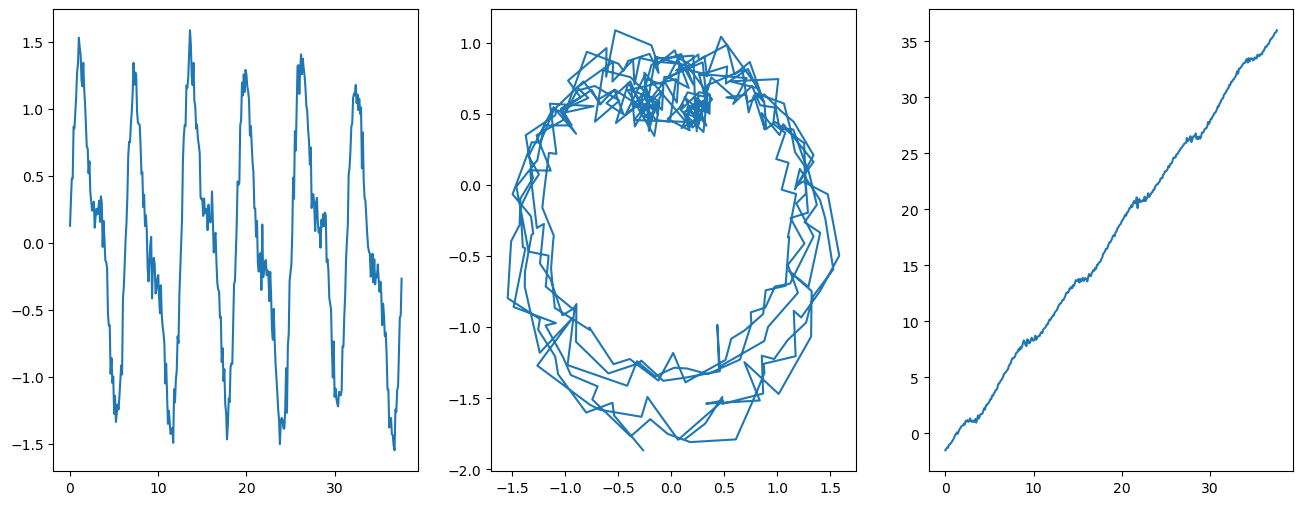

In [76]:
t = np.arange(0, 2*np.pi*6.0, 0.10)
y = np.sin(t) + 0.50*np.sin(2*t) + 0.20*np.sin(0.5*t) + 0.10*np.random.randn(t.shape[0])

analytic_signal = hilbert(y)
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.plot(t,y)
ax2.plot(np.real(analytic_signal), np.imag(analytic_signal));

phase_est = np.unwrap(np.angle(analytic_signal))
amplitude_est = np.abs(analytic_signal) 

ax3.plot(t, phase_est);

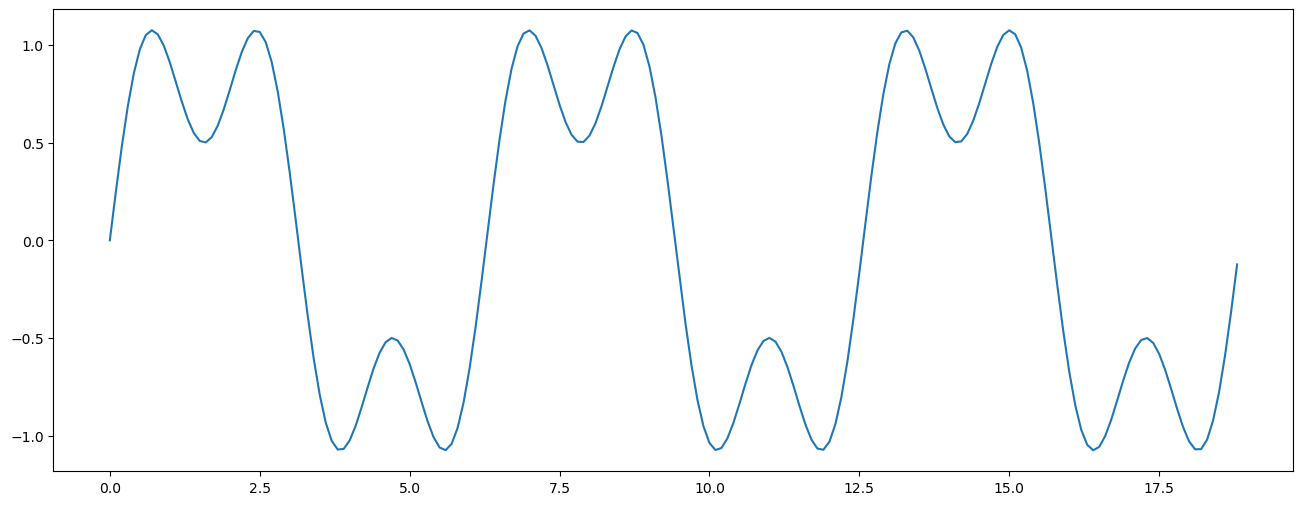

In [77]:
t = np.arange(0,2*np.pi*3, 1e-1)
y = np.sin(t)+0.50*np.sin(3*t)

plt.plot(t,y);

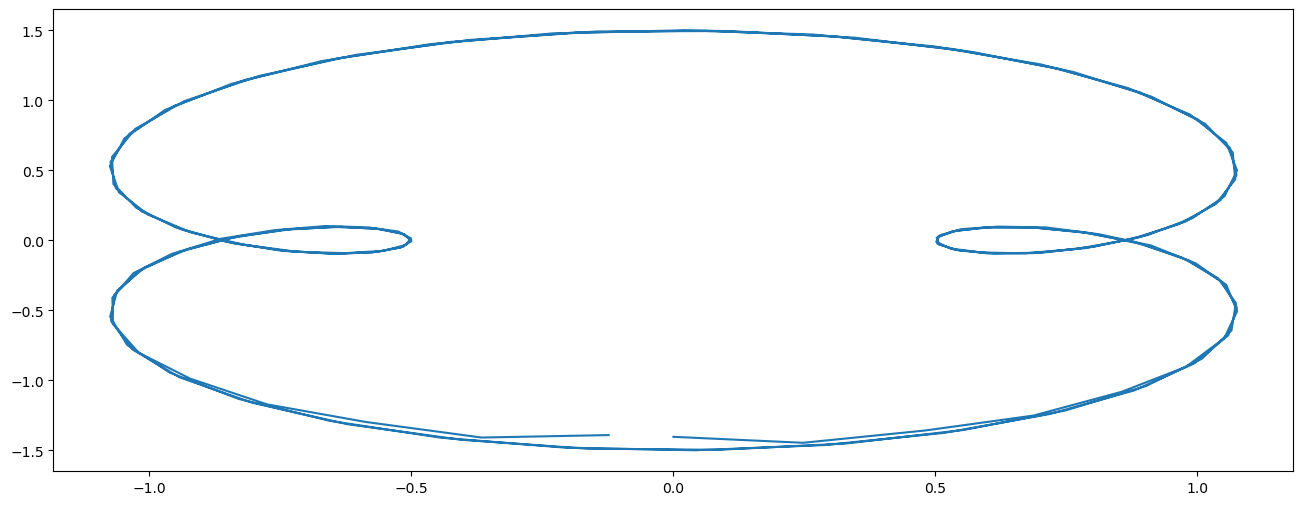

In [78]:
analytic_signal = hilbert(y);
plt.plot(np.real(analytic_signal), np.imag(analytic_signal));

In [79]:
# Length embedding of the protophase

In [80]:
# Translated

import numpy as np

def co_fbtransf1(theta, nfft=80, alpha=0.05, ngrid=50):
    Spl = np.zeros((nfft, 1))
    al2 = alpha * alpha

    IN = np.where(np.diff(np.mod(theta, 2 * np.pi)) < 0)[0]
    npt = len(theta[IN[0] : IN[-1]])
    for k in range(1, nfft + 1):
        Spl[k - 1] = sum(np.exp(-1j * k * theta[IN[0] : IN[-1]])) / npt

    phi = theta
    if ngrid:
        arg = np.linspace(0, 2 * np.pi, ngrid, endpoint=False)
        sigma = np.ones((ngrid, 1))
        for k in range(1, nfft + 1):
            kernel = np.exp(-0.5 * k * k * al2)
            sigma += kernel * 2 * np.real(Spl[k - 1] * np.exp(1j * k * arg))
            phi += kernel * 2 * np.imag(Spl[k - 1] * (np.exp(1j * k * theta) - 1) / k)
        return phi, arg, sigma
    else:
        for k in range(1, nfft + 1):
            phi += np.exp(-0.5 * k * k * al2) * 2 * np.imag(Spl[k - 1] * (np.exp(1j * k * theta) - 1) / k)
        return phi


Sampling Hz 100.0


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


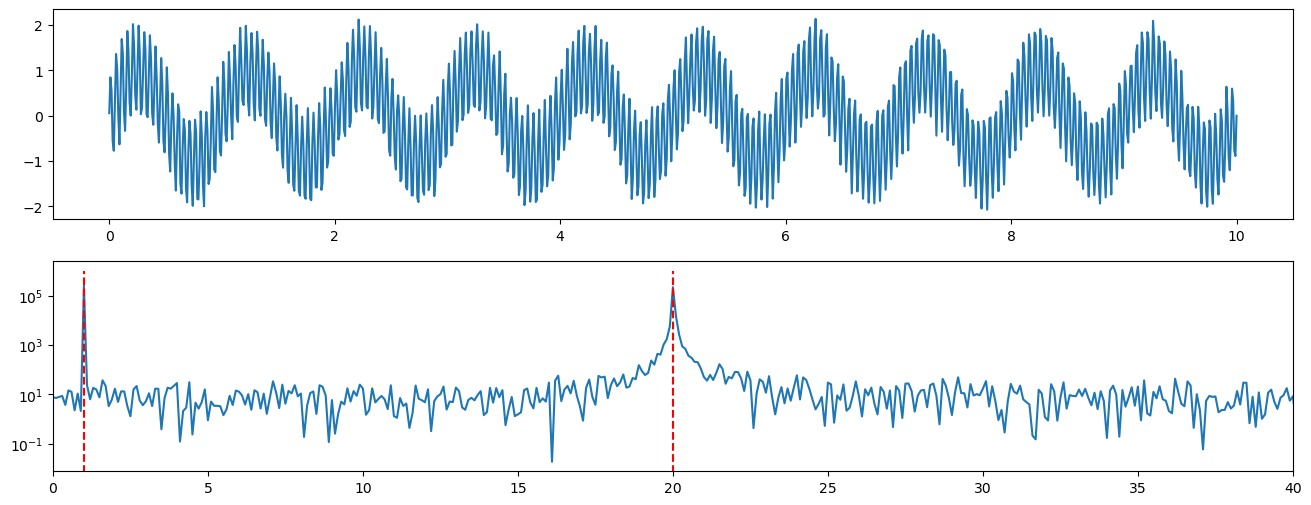

In [81]:
num_samples = 1000
x = np.linspace(0, 10, num_samples)
y = np.sin(2*np.pi*x) + 1.0*np.sin(2*np.pi*20*x) + 0.10*np.random.randn(num_samples)
fs = np.fft.fft(y) 
psd = fs*np.conjugate(fs)
time_step = x[-1]/ len(x)
print(f"Sampling Hz {1.0/time_step}")
freqs = np.fft.fftfreq(y.size, time_step)
idx = np.argsort(freqs)
fid, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[1].semilogy(freqs[idx], psd[idx])
ax[1].set_xlim(0,40.0)
ax[1].vlines([1.0,20.0], ymin=0, ymax=1e6, colors=['red', 'red'], ls='--')

In [82]:
import numpy as np
from scipy import signal, ndimage
from scipy.interpolate import interp1d

import pywt

import matplotlib.pyplot as plt

from matplotlib.colors import Normalize, LogNorm, NoNorm
from matplotlib.cm import get_cmap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import time

In [83]:
def cwt_spectrogram(x, fs, nNotes=12, detrend=True, normalize=True, sigma_smooth: float = 2.0):
    
    N = len(x)
    dt = 1.0 / fs
    times = np.arange(N) * dt

    ###########################################################################
    # detrend and normalize
    if detrend:
        x = signal.detrend(x,type='linear')
    if normalize:
        stddev = x.std()
        x = x / stddev

    ###########################################################################
    # Define some parameters of our wavelet analysis. 

    # maximum range of scales that makes sense
    # min = 2 ... Nyquist frequency
    # max = np.floor(N/2)

    nOctaves = int(np.log2(2*np.floor(N/2.0)))
    scales = 2**np.arange(1, nOctaves, 1.0/nNotes)
    
#     print (scales)

    ###########################################################################
    # cwt and the frequencies used. 
    # Use the complex morelet with bw=1.5 and center frequency of 1.0
    coef, freqs=pywt.cwt(x,scales,'cmor1.5-1.0')
    frequencies = pywt.scale2frequency('cmor1.5-1.0', scales) / dt
    
    ###########################################################################
    # power
#     power = np.abs(coef)**2
    power = np.abs(coef * np.conj(coef))
    
    # smooth a bit
    power = ndimage.gaussian_filter(power, sigma=sigma_smooth)

    ###########################################################################
    # cone of influence in frequency for cmorxx-1.0 wavelet
    f0 = 2*np.pi
    cmor_coi = 1.0 / np.sqrt(2)
    cmor_flambda = 4*np.pi / (f0 + np.sqrt(2 + f0**2))
    # cone of influence in terms of wavelength
    coi = (N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2))
    coi = cmor_flambda * cmor_coi * dt * coi
    # cone of influence in terms of frequency
    coeff = 1.0/coi


    return power, times, frequencies, coeff

In [84]:


def spectrogram_plot(z, 
                     times, 
                     frequencies, 
                     coif, 
                     cmap=None, 
                     norm=Normalize(), 
                     ax=None, 
                     colorbar=True):
    ###########################################################################
    # plot
    
    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = plt.gcf()

    xx,yy = np.meshgrid(times,frequencies)
    ZZ = z
    
    
    im = ax.pcolor(xx,yy,ZZ, norm=norm, cmap=cmap)
    ax.plot(times,coif)
    ax.fill_between(times,coif, step="mid", alpha=0.4)
    
    if colorbar:
        cbaxes = inset_axes(ax, width="2%", height="90%", loc=4) 
        fig.colorbar(im,cax=cbaxes, orientation='vertical')

    ax.set_xlim(times.min(), times.max())
    ax.set_ylim(frequencies.min(), frequencies.max())

    return ax

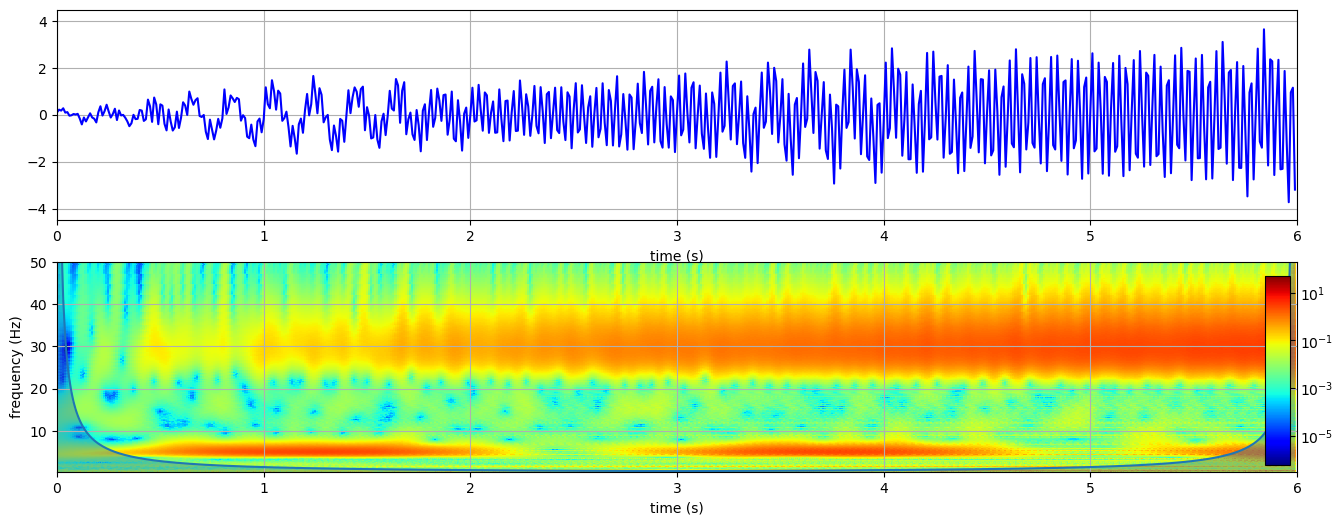

In [86]:
plt.rcParams['figure.figsize'] = (16, 6)

total_duration = 6.0
sampling_frequency = 100 #Hz
sample_times = np.arange(0,total_duration, 1.0/sampling_frequency)
wav_data = np.sin(2*np.pi*0.20*sample_times)**2*np.sin(2*np.pi*5*sample_times) + 0.50*sample_times*np.sin(2*np.pi*30*(1.0+sample_times)) + 0.20*np.random.randn(len(sample_times))

#plt.plot(sample_times, np.sin(2*np.pi*0.20*sample_times)**2*np.sin(2*np.pi*5*sample_times))

###########################################################################
# calculate spectrogram
power, times, frequencies, coif = cwt_spectrogram(wav_data, sampling_frequency, nNotes=200, sigma_smooth=0.5)

###########################################################################
# plot



fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(sample_times, wav_data, color='b');

ax1.set_xlim(0, total_duration)
ax1.set_xlabel('time (s)')
ax1.set_ylim(-np.abs(wav_data).max()*1.2,np.abs(wav_data).max()*1.2)
ax1.grid(True)
# ax1.axis('off')
spectrogram_plot(power, times, frequencies, coif, cmap='jet', norm=LogNorm(), ax=ax2)

ax2.set_xlim(0, total_duration)
# ax2.set_ylim(0, 0.5*sampling_frequency)
ax2.set_ylim(2.0/total_duration, 0.5*sampling_frequency)
ax2.set_xlabel('time (s)')
ax2.set_ylabel('frequency (Hz)');

ax2.grid(True)

